# **IMPUTACION ESPACIOTEMPORAL DE SERIES DE PRECIPITACION**
En este notebook se realiza la imputacion de datos en la serie de precipitacion del CCCP con series de precipitacion de la base de datos de CHIRPS  para poder tener una serie continua, se utilizan modelos estacionarios como SARIMA

## **Proceso ETL**
---
## 1. Datos de la Red MPOMM
- Obtencion de los datos de la serie de precipitaicond e la base de datos de Red_MPOMM

In [1]:
from api_somo import DataFetcher, fetch_qf 
import logging

# Setting up logging for the main script
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/filter-serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date":"2009-01-01",
    "end_date":"2012-12-31"
    }

try:
    # 1. Fetch and process the data
    red_mpomm_serie = DataFetcher.fetch_and_process_data(api_url, params)

    if red_mpomm_serie.empty:
        raise ValueError("The historical series is empty.")

    # Additional processing with the historical series
    logger.info(f"Fetched historical series: {red_mpomm_serie.head(0)}")

except Exception as e:
    logger.error(f"Error fetching historical series: {e}")


display(red_mpomm_serie)

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/filter-serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2012-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag', 'latitude', 'longitude']
INFO:api_somo:Columns after renaming: ['timestamp', 'value', 'qf', 'latitude', 'longitude']
INFO:api_somo:Timestamp conversion and indexing complete.
INFO:__main__:Fetched historical series: Empty DataFrame
Columns: [value, qf, latitude, longitude]
Index: []


,value,qf,latitude,longitude
timestamp,,,,
2009-02-01 05:10:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:20:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:30:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:40:00+00:00,0.0,1,1.82011,-78.72871
2009-02-01 05:50:00+00:00,0.0,1,1.82011,-78.72871
...,...,...,...,...
2012-12-31 04:20:00+00:00,0.1,1,1.82011,-78.72871
2012-12-31 04:30:00+00:00,0.0,1,1.82011,-78.72871
2012-12-31 04:40:00+00:00,0.1,1,1.82011,-78.72871


### ETL-Red MPOMM
---
#### Preprocesamiento de los datos de la redmpomm

- Se convierten a **NaN** los datos que tienen bandera de calidad distinta de 'bueno' y se realiza un reporte de cuantos datos nulos quedaron

In [2]:
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
import numpy as np
from graphics_utils.express import fig_histogram
red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1, 3]), 'value'] = np.nan
red_mpomm_serie.isnull().sum()


value        13090
qf               0
latitude         0
longitude        0
dtype: int64

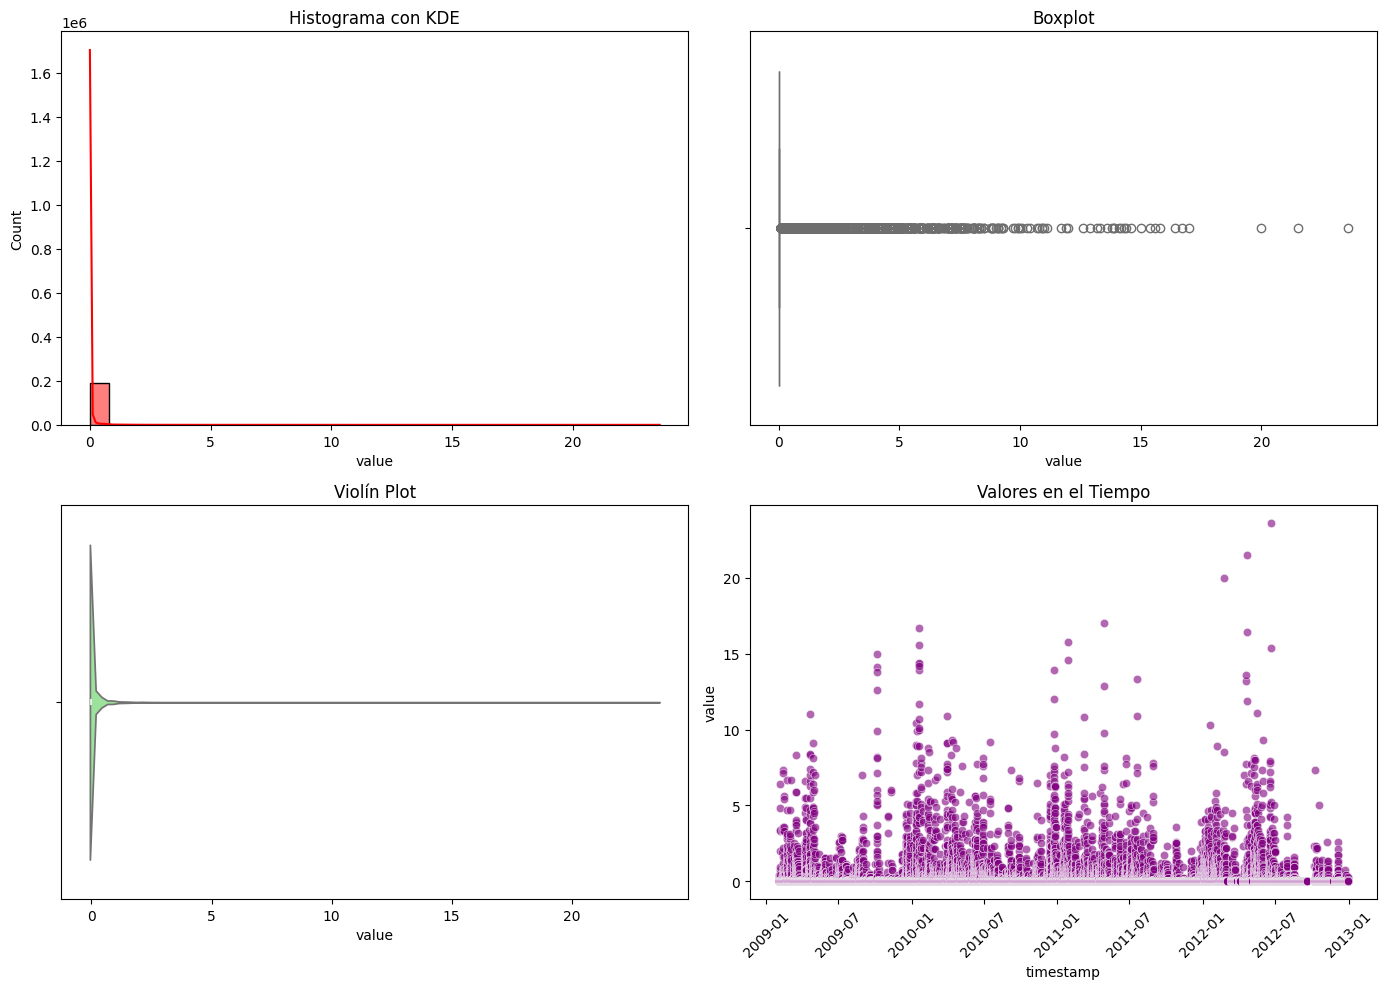

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el tamaño del subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma con KDE
sns.histplot(red_mpomm_serie['value'], bins=30, kde=True, ax=axes[0, 0], color="red")
axes[0, 0].set_title("Histograma con KDE")

# Boxplot
sns.boxplot(x=red_mpomm_serie['value'], ax=axes[0, 1], color="lightcoral")
axes[0, 1].set_title("Boxplot")

# Violin plot
sns.violinplot(x=red_mpomm_serie['value'], ax=axes[1, 0], color="lightgreen")
axes[1, 0].set_title("Violín Plot")

# Scatter Plot (Distribución de valores en el tiempo)
sns.scatterplot(x=red_mpomm_serie.index, y=red_mpomm_serie['value'], ax=axes[1, 1], color="purple", alpha=0.6)
axes[1, 1].set_title("Valores en el Tiempo")
axes[1, 1].tick_params(axis='x', rotation=45)

# Ajustar la distribución
plt.tight_layout()
plt.show()


- Se realiza un remuestreo con la funcion predeterminada, y se vuelve a remplazar con **NaN** los datos que tengan calidad distinta a 'bueno'

In [4]:
from utils.utils import reshample_time_serie
serie_resample=reshample_time_serie(red_mpomm_serie, nueva_frecuencia='D', metodo='sum')
display(serie_resample.columns)
# Aplicar la condición para reemplazar 'value' con NaN si 'qf' no es 1
serie_resample['value'] = serie_resample['value'].where(serie_resample['qf'] == 1, np.nan)
serie_resample


Index(['value', 'qf', 'latitude', 'longitude'], dtype='object')

,value,qf,latitude,longitude
timestamp,,,,
2009-02-01,0.0,1,1.82011,-78.72871
2009-02-02,0.7,1,1.82011,-78.72871
2009-02-03,23.3,1,1.82011,-78.72871
2009-02-04,0.0,1,1.82011,-78.72871
2009-02-05,0.0,1,1.82011,-78.72871
...,...,...,...,...
2012-12-27,0.0,1,1.82011,-78.72871
2012-12-28,0.0,1,1.82011,-78.72871
2012-12-29,0.0,1,1.82011,-78.72871


- Muestra la cantidad de Nan en el dataset
- Crear el dataset de trabajo

In [5]:
from numpy import histogram
from graphics_utils.express import fig_pie_month, fig_histogram
pie_fig = fig_pie_month(red_mpomm_serie, params)
histogram_fig =fig_histogram(serie_resample, params)
pie_fig.show()
histogram_fig.show()

In [6]:
import pandas as pd

dataset = serie_resample['value'].to_frame()

display(dataset.isnull().sum())

# Mostrar el resultado
display(dataset)



value    176
dtype: int64

,value
timestamp,
2009-02-01,0.0
2009-02-02,0.7
2009-02-03,23.3
2009-02-04,0.0
2009-02-05,0.0
...,...
2012-12-27,0.0
2012-12-28,0.0
2012-12-29,0.0


## 2. Datos de CIRPS

### Obtener los datos del data warehouse
- En este df se extraen los datos mas cercanos al punto al cual se le realiza la imputacion, la inspeccion fue visual para determinar dichos puntos 

In [7]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure, OperationFailure
import pandas as pd

try:
    # Conexión a MongoDB
    print("Intentando conectar a MongoDB...")
    client = MongoClient('localhost', 27017)  # Cambia los parámetros si es necesario
    print("Conexión a MongoDB exitosa.")

    # Selecciona la base de datos y la colección
    db = client['CHIRPS']
    collection = db['sensor_data']

    print(client['EVC-SOMMO'].list_collection_names())  # Lista las colecciones de la base de datos


    # Consulta para obtener todos los documentos de la colección
    print("Obteniendo documentos de la colección...")
    data = collection.find()  # Esto devuelve un cursor iterable

    # Convertir el cursor a una lista
    data_list = list(data)

    if not data_list:
        print("No se encontraron documentos.")
    else:
        # Crear listas para almacenar los datos extraídos
        points = []
        timestamps = []

        # Recorrer los documentos y extraer los datos relevantes
        for document in data_list:
            timestamp = document.get('timestamp')  # Extrae el timestamp
            points_data = document.get('point_data', [])  # Extrae el array de puntos

            for point in points_data:
                point_dict = {
                    'point_id': point.get('point_id'),
                    'latitude': point.get('latitude'),
                    'longitude': point.get('longitude'),
                    'value': point.get('value'),
                    'timestamp': timestamp  # Incluir timestamp para cada punto
                }
                points.append(point_dict)

        # Convertir los puntos a un DataFrame
        print(f"Se encontraron {len(points)} puntos. Convirtiendo a DataFrame...")
        df = pd.DataFrame(points)

        # Si la colección tiene un campo '_id', lo eliminamos para evitar problemas
        if '_id' in df.columns:
            df = df.drop(columns=['_id'])
        
        # Filtrar los puntos deseados
        selected_points = ['point_6', 'point_10', 'point_12']
        df = df[df['point_id'].isin(selected_points)]

        # Mostrar las primeras filas del DataFrame
        print("DataFrame creado con éxito:")
        display(df.head(5))

except ConnectionFailure as e:
    print(f"Error al conectar con MongoDB: {e}")
except OperationFailure as e:
    print(f"Error en la operación de MongoDB: {e}")
except Exception as e:
    print(f"Error inesperado: {e}")


Intentando conectar a MongoDB...
Conexión a MongoDB exitosa.
[]
Obteniendo documentos de la colección...
Se encontraron 60996 puntos. Convirtiendo a DataFrame...
DataFrame creado con éxito:


,point_id,latitude,longitude,value,timestamp
5,point_6,1.774998,-78.725006,0.000000,2009-02-01
9,point_10,1.824997,-78.725006,0.000000,2009-02-01
11,point_12,1.824997,-78.775000,0.000000,2009-02-01
17,point_6,1.774998,-78.725006,0.000000,2009-02-02
21,point_10,1.824997,-78.725006,12.457714,2009-02-02


### ETL-CHIRPS
- Transformacion del formato, se extraen las series temporales continuas y que coinciden con la marca de tiempo, esto se realiza para obtener el formato para añadir al dataset de trabajo

In [8]:
import pandas as pd

# Suponiendo que df es tu dataset original
df['timestamp'] = pd.to_datetime(df['timestamp'])  # Asegurar que sea datetime

# Crear la tabla pivotante con fecha como índice y cada punto como columna
df_pivot = df.pivot_table(index='timestamp', columns='point_id', values='value')

# Mostrar el DataFrame resultante
display(df_pivot)



point_id,point_10,point_12,point_6
timestamp,,,
2009-02-01,0.000000,0.000000,0.000000
2009-02-02,12.457714,16.109703,0.000000
2009-02-03,12.457714,16.109703,29.260645
2009-02-04,0.000000,0.000000,0.000000
2009-02-05,0.000000,0.000000,0.000000
...,...,...,...
2022-12-28,0.000000,0.000000,7.627149
2022-12-29,0.000000,0.000000,0.000000
2022-12-30,0.000000,0.000000,11.136356


- Se filtran y vuelven nan los datos que superan el umbral 

In [9]:
# Reemplazar los valores mayores a 500 por NaN
df_pivot = df_pivot.mask(df_pivot > 500)
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
df_pivot.isnull().sum()


point_id
point_10    1
point_12    0
point_6     6
dtype: int64

## **Analisis de los datos**
---
### Dataset
- Se añade al dataset los datos de CHIRPS y se calcula las dimenciones del dataset

In [10]:
# Convertir el índice de df_pivot a naive (sin zona horaria)
df_pivot.index = df_pivot.index.tz_localize(None)

# Si dataset también tiene una columna de fecha, conviértela a datetime sin zona horaria
dataset.index = pd.to_datetime(dataset.index).tz_localize(None)

# Intentar unir los DataFrames nuevamente
dataset = dataset.join(df_pivot, how='inner')
display(dataset.shape)
dataset


(1430, 4)

,value,point_10,point_12,point_6
timestamp,,,,
2009-02-01,0.0,0.000000,0.000000,0.000000
2009-02-02,0.7,12.457714,16.109703,0.000000
2009-02-03,23.3,12.457714,16.109703,29.260645
2009-02-04,0.0,0.000000,0.000000,0.000000
2009-02-05,0.0,0.000000,0.000000,0.000000
...,...,...,...,...
2012-12-27,0.0,0.000000,0.000000,0.000000
2012-12-28,0.0,0.000000,0.000000,0.000000
2012-12-29,0.0,0.000000,0.000000,0.000000


### Graficar las series temporales
- Se grafican las series del dataset para tener una vision general del comportamiento de cada una

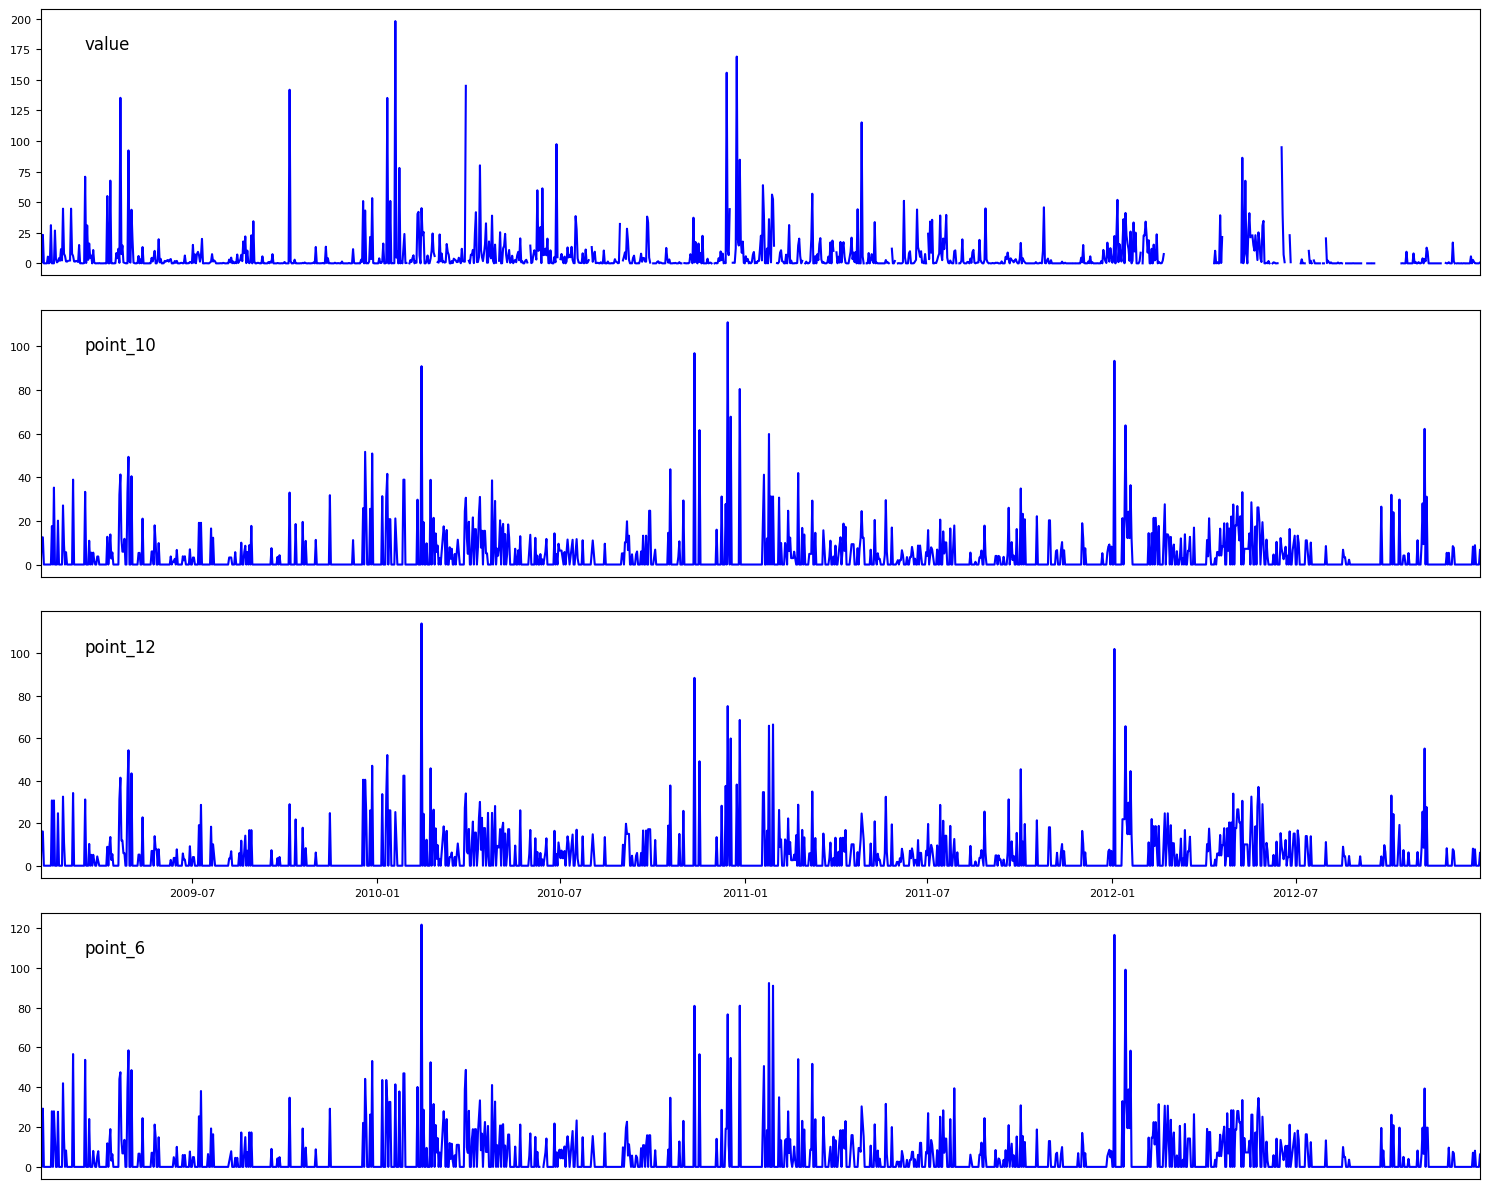

In [11]:
import matplotlib.pyplot as plt
# Gráficar
fig, axs = plt.subplots(nrows=dataset.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(dataset.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset.index, dataset[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset.index.min(), dataset.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
    if i != len(dataset.columns[1:]) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('', fontsize=6)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

### Grafico espacial
- estracion de coordenadas.

Se extraen las coordenadas de mongo y de la serie de la red mpomm de manera dinamica.

In [12]:
# Extraer las ubicaciones únicas
locations_df = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)

# Convertir red_mpomm_serie[0] en un DataFrame (si no lo es)
new_locations = pd.DataFrame(red_mpomm_serie[['latitude', 'longitude']].drop_duplicates())

# Concatenar ambos DataFrames y eliminar duplicados
locations_df = pd.concat([locations_df, new_locations]).drop_duplicates().reset_index(drop=True)

# Mostrar el resultado
print(locations_df)



   latitude  longitude
0  1.774998 -78.725006
1  1.824997 -78.725006
2  1.824997 -78.775000
3  1.820110 -78.728710


- Se crea el mapa y se grafican los puntos que estan disponibles

In [13]:
import folium

# Crear el mapa centrado en la ubicación promedio
map_center = [locations_df['latitude'].mean(), locations_df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Agregar marcadores al mapa
for _, row in locations_df.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                popup=f"Lat: {row['latitude']}, Lon: {row['longitude']}").add_to(m)

# Mostrar el mapa (en un entorno compatible como Jupyter Notebook)
m


### Correlaciones entre los datos
- Ajustamos los datos eliminando los nan y garantizamos que la matriz sea cuadrada para su trabajo

In [14]:
# Crear un dataframe con solo las filas con datos en todas las columnas
dataset_no_nan = dataset.dropna()
dataset_no_nan.shape

(1252, 4)

- grafico de las series continuas 

Inspeccion visual del estado de las series que se encuentran en el dataset ademas de un informe numerico para corroborar la inexistencia de registros nan.

value       0
point_10    0
point_12    0
point_6     0
dtype: int64

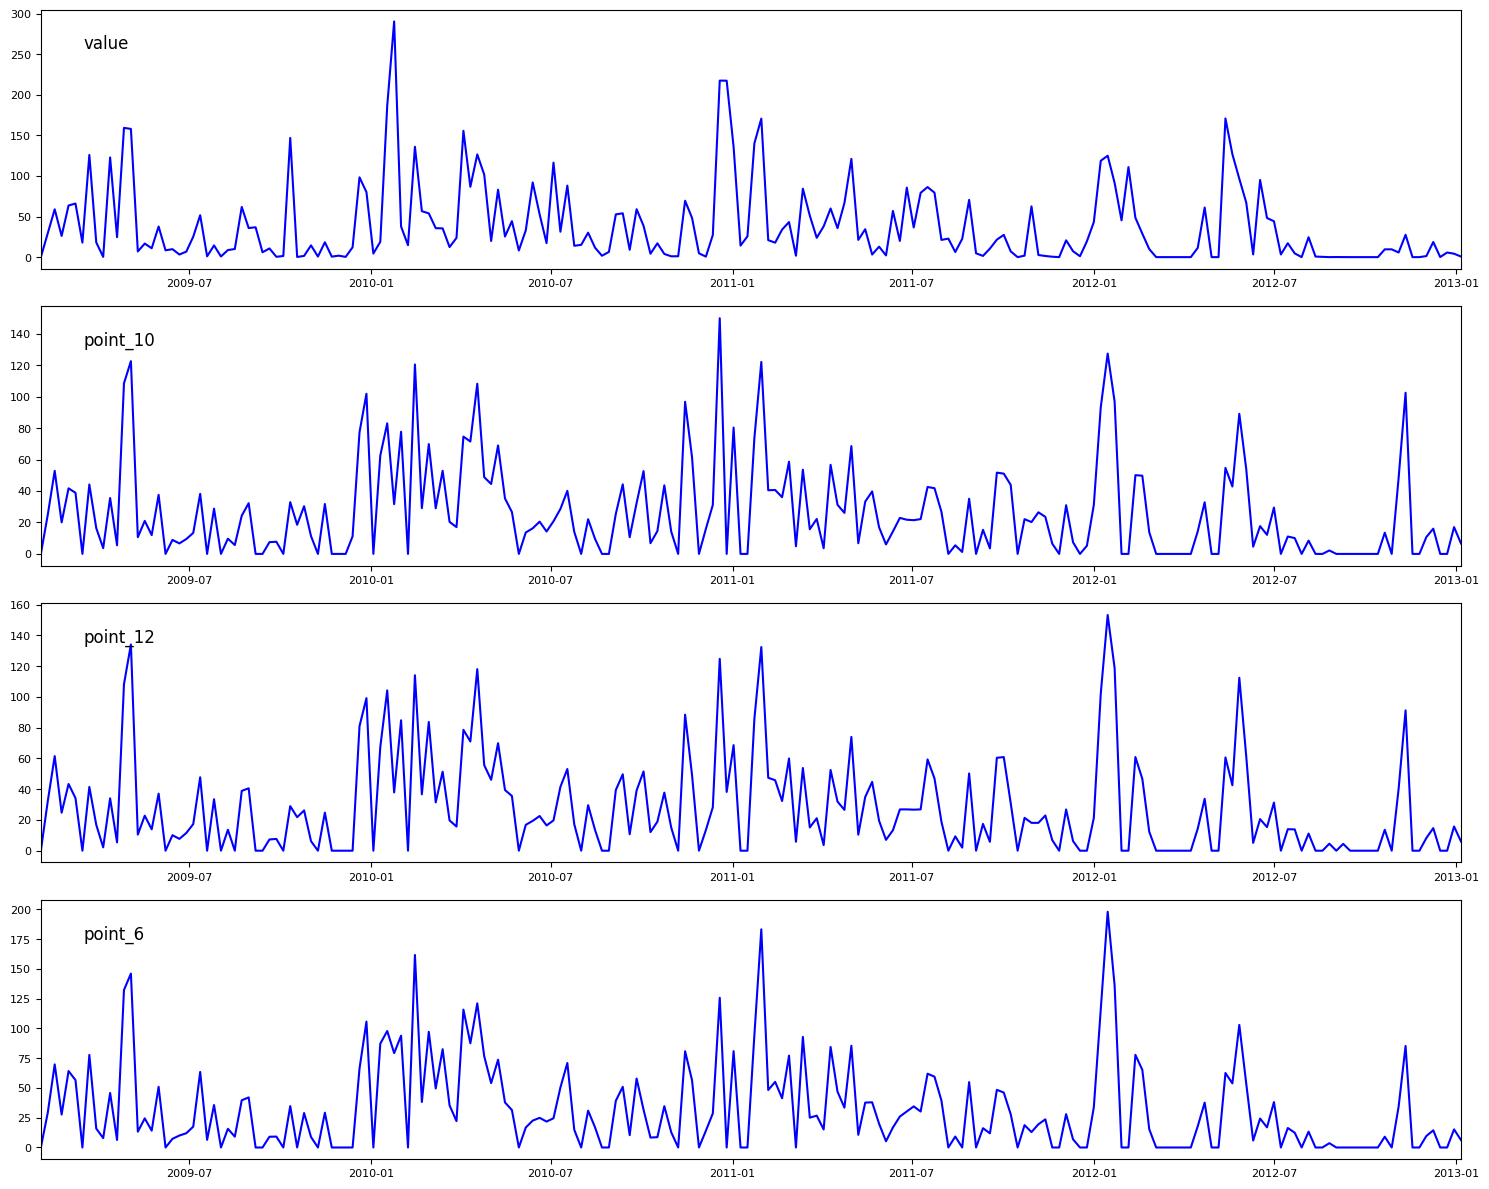

In [15]:

# Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos

display(dataset_no_nan.isnull().sum())

dataset_no_nan = dataset_no_nan.resample('W').sum()
# Filtrar solo los valores mayores que 0 en el DataFrame
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos > 0]
#estaciones_con_datos = estaciones_con_datos[estaciones_con_datos < 1500] # filtro que se coloca por unos datos sospechosos que se intentan comparar toman valores demasiado altos


# Gráficar
fig, axs = plt.subplots(nrows=dataset_no_nan.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(dataset_no_nan.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset_no_nan.index, dataset_no_nan[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset_no_nan.index.min(), dataset_no_nan.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

- Metodo numerico de correlaciones

Matriz que obtiene los valores cuantitativos de la correlacionde las series del dataset 

- Metodo grafico de correlaciones

Imagen de matriz de correlacion en la cual se aprecian tendencias outliyers y otra clase de informacion alterna de las series

,value,point_10,point_12,point_6
value,1.000000,0.673554,0.702595,0.713554
point_10,0.673554,1.000000,0.979369,0.956049
point_12,0.702595,0.979369,1.000000,0.965564
point_6,0.713554,0.956049,0.965564,1.000000


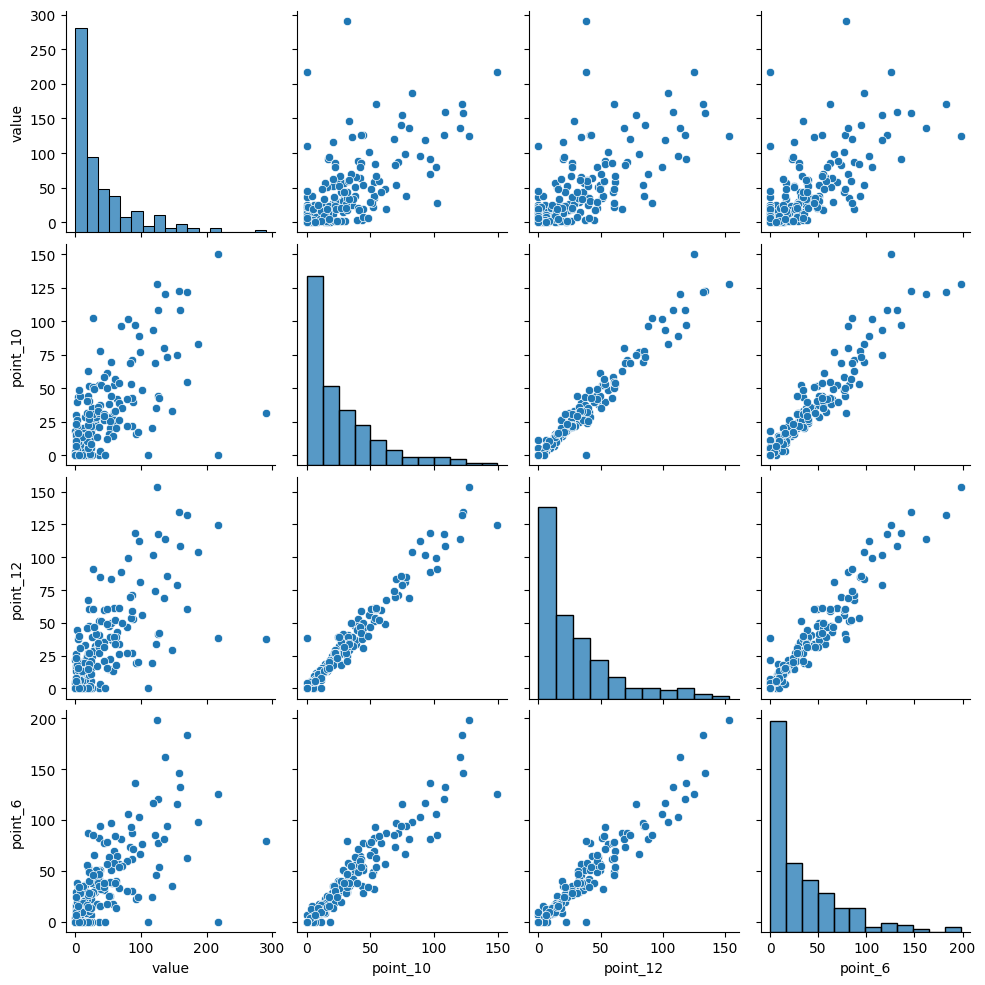

In [16]:
import seaborn as sns 
# Método gráfico de dispersión
sns.pairplot(dataset_no_nan)
# Metodo numerico
dataset_no_nan.corr()

- Matriz de confusion

Con esta analizamos de manera mas legible el estado de las correlaciones que tenemos en el dataset, con esto se analiza la calidad de los datos para la imputacion

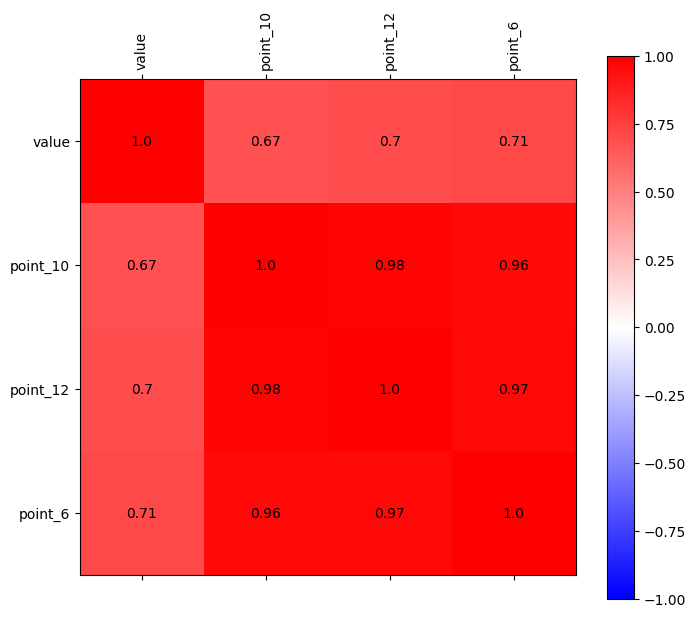

In [17]:
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
matriz = dataset_no_nan.corr()

# Crear la figura de la matriz de correlación
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)

# Configurar etiquetas de los ejes X e Y
plt.xticks(range(len(matriz.columns)), dataset_no_nan.columns, rotation=90)
plt.yticks(range(len(matriz.columns)), dataset_no_nan.columns)

# Agregar los valores de la correlación en cada celda de la matriz
for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2), ha="center", va="center", color="black")

# Agregar barra de colores
plt.colorbar()

# Ajustar el tamaño de la figura
plt.gcf().set_size_inches(8, 7)

# Mostrar la matriz de correlación
plt.show()


## **Imputaicon de datos**
---

- Visualizar el estado inicial del *dataset* en cuestrion de valores nulos  y Nan para tener idea de los rellenos 

In [18]:
dataset.isnull().sum()

value       176
point_10      0
point_12      0
point_6       2
dtype: int64

- Creamos el **dataset_model** variable que contiene las tres series que se van a trabajar en el modelo

- Creamos **fechas_con_datos** la cual contiene el df anterior pero eliminando las filas o registros con datos Nan

In [19]:
#Organizamos un dataframe con tres estaciones (2 estaciones para ser predictoras y 1 para ser predecida)
dataset_model = dataset[["point_12", "point_6", "value"]] #ajuste

#Solo se dejan las filas que tengan datos en las tres estaciones
fechas_con_datos = dataset_model.dropna() #ajuste

dataset_model.head(2)

,point_12,point_6,value
timestamp,,,
2009-02-01,0.000000,0.0,0.0
2009-02-02,16.109703,0.0,0.7


- usamos el modelo de arbol de deciciones ajustado a los datos con algunas metricas para la evaluacion del modelo.

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Entrenar el modelo con dos variables predictoras
X = fechas_con_datos[['point_12', 'point_6']]
y = fechas_con_datos['value']

# 2. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Ajustar el modelo Random Forest
model = RandomForestRegressor(
    n_estimators=316,  # Número de árboles
    max_depth=10,  # Máxima profundidad de los árboles
    min_samples_split=28,  # Mínimo de muestras para dividir un nodo
    min_samples_leaf=18,  # Mínimo de muestras en cada hoja
    random_state=42,
    n_jobs=-1  # Uso de todos los núcleos
)

# Entrenar el modelo
model.fit(X_train, y_train)

# 4. Predicción
y_pred = model.predict(X_test)

print(len(y), len(y_pred))

# 5. Evaluación del modelo
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")

# 6. Importancia de características
feature_importances = pd.DataFrame(
    {"Feature": X.columns, "Importance": model.feature_importances_}
).sort_values(by="Importance", ascending=False)

print(feature_importances)


1252 251
MAE: 7.48
R²: 0.30
    Feature  Importance
0  point_12    0.506724
1   point_6    0.493276


- Rutina para definir el mejor grutpo de parametros por selecion aleatoria y evaluacion


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definir el rango de valores para cada parámetro
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': randint(5, 50),
    'min_samples_leaf': randint(1, 20)
}

# Realizar búsqueda aleatoria
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=200, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"Mejores parámetros aleatorios: {random_search.best_params_}")
print(f"Mejor puntuación aleatoria: {random_search.best_score_:.2f}")


Mejores parámetros aleatorios: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 47, 'n_estimators': 200}
Mejor puntuación aleatoria: 0.20


#### Análisis de Importancia de Características y Evaluación del Modelo

- Se usa SHAP para analizar la contribución de cada variable en las predicciones del modelo. Se crea un explainer con el modelo entrenado y el conjunto de entrenamiento (X_train), y luego se calculan los valores SHAP para el conjunto de prueba (X_test).

Se generan dos gráficos para analizar la importancia de las variables:

1. SHAP Summary Plot: Muestra cómo cada característica afecta la predicción del modelo.

2. Gráfico de Barras: Representa la importancia de cada variable en función de su impacto en la predicción.

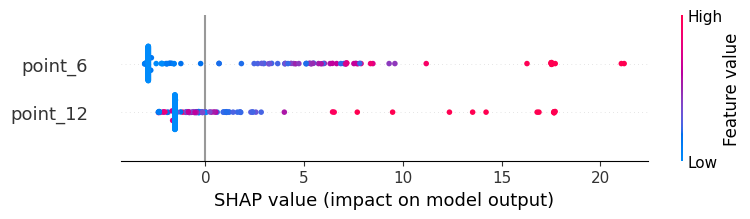

C:\Users\dreng\AppData\Local\Temp\ipykernel_27308\1343808839.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




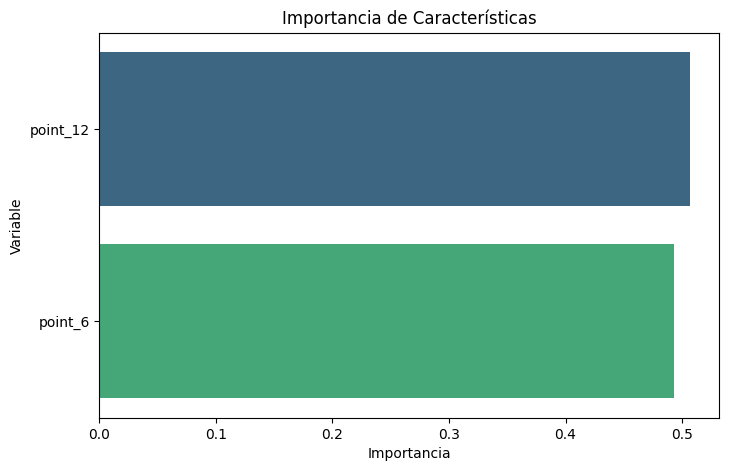

MAE: 7.48
RMSE: 13.41
R²: 0.30


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# Crear un explainer de SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Gráfico de importancia de características con SHAP
plt.figure(figsize=(10, 5))
shap.summary_plot(shap_values, X_test)

plt.figure(figsize=(8, 5))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.title("Importancia de Características")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

# 5. Mostrar métricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Se calculan tres métricas clave para evaluar el rendimiento del modelo:

- MAE (Error Absoluto Medio): Promedio de los errores absolutos.

- RMSE (Raíz del Error Cuadrático Medio): Mide la dispersión de los errores.

- R² (Coeficiente de Determinación): Evalúa qué tan bien el modelo explica la variabilidad de los datos.

Un MAE y RMSE bajos indican un buen ajuste, mientras que un R² cercano a 1 significa que el modelo explica bien la varianza de los datos.

---
### Análisis de Correlación y Estacionariedad de la Serie Temporal

#### 1. Correlación de Spearman  
Se calcula la correlación entre las variables `point_12` y `point_6` usando el coeficiente de Spearman, que mide la relación monótona (no necesariamente lineal) entre dos variables.

- Un valor cercano a **1** indica una alta correlación positiva.
- Un valor cercano a **-1** indica una alta correlación negativa.
- Un valor cercano a **0** indica que no hay relación significativa.


In [23]:
#test
from scipy.stats import spearmanr

corr_12_6_spearman, _ = spearmanr(X['point_12'], X['point_6'])
print(f"Correlación de Spearman entre point_12 y point_6: {corr_12_6_spearman:.2f}")

from statsmodels.tsa.stattools import adfuller

result = adfuller(dataset['value'].dropna())
print(f"Estadística ADF: {result[0]:.4f}")
print(f"P-valor: {result[1]:.4f}")
print(f"Valor crítico (1%): {result[4]['1%']:.4f}")


Correlación de Spearman entre point_12 y point_6: 0.90
Estadística ADF: -8.8087
P-valor: 0.0000
Valor crítico (1%): -3.4356


# 📊 Análisis y Evaluación del Modelo de Predicción

Este análisis incluye la evaluación del desempeño del modelo utilizando diferentes métricas, la interpretación de la importancia de características y diversas visualizaciones para entender la relación entre las predicciones y los valores reales.

## 🏆 1. Métricas de Desempeño  
Se calcularon las siguientes métricas para evaluar la calidad del modelo:

- **MAE (Mean Absolute Error):** Mide el error promedio absoluto.
- **RMSE (Root Mean Squared Error):** Penaliza más los errores grandes.
- **R² (Coeficiente de Determinación):** Indica qué tan bien se ajusta el modelo a los datos.
- **Validación Cruzada (R² promedio):** Evalúa la estabilidad del modelo en diferentes particiones de los datos.



MAE: 7.4830
RMSE: 13.4127
R²: 0.3018
R² de validación cruzada: 0.1490


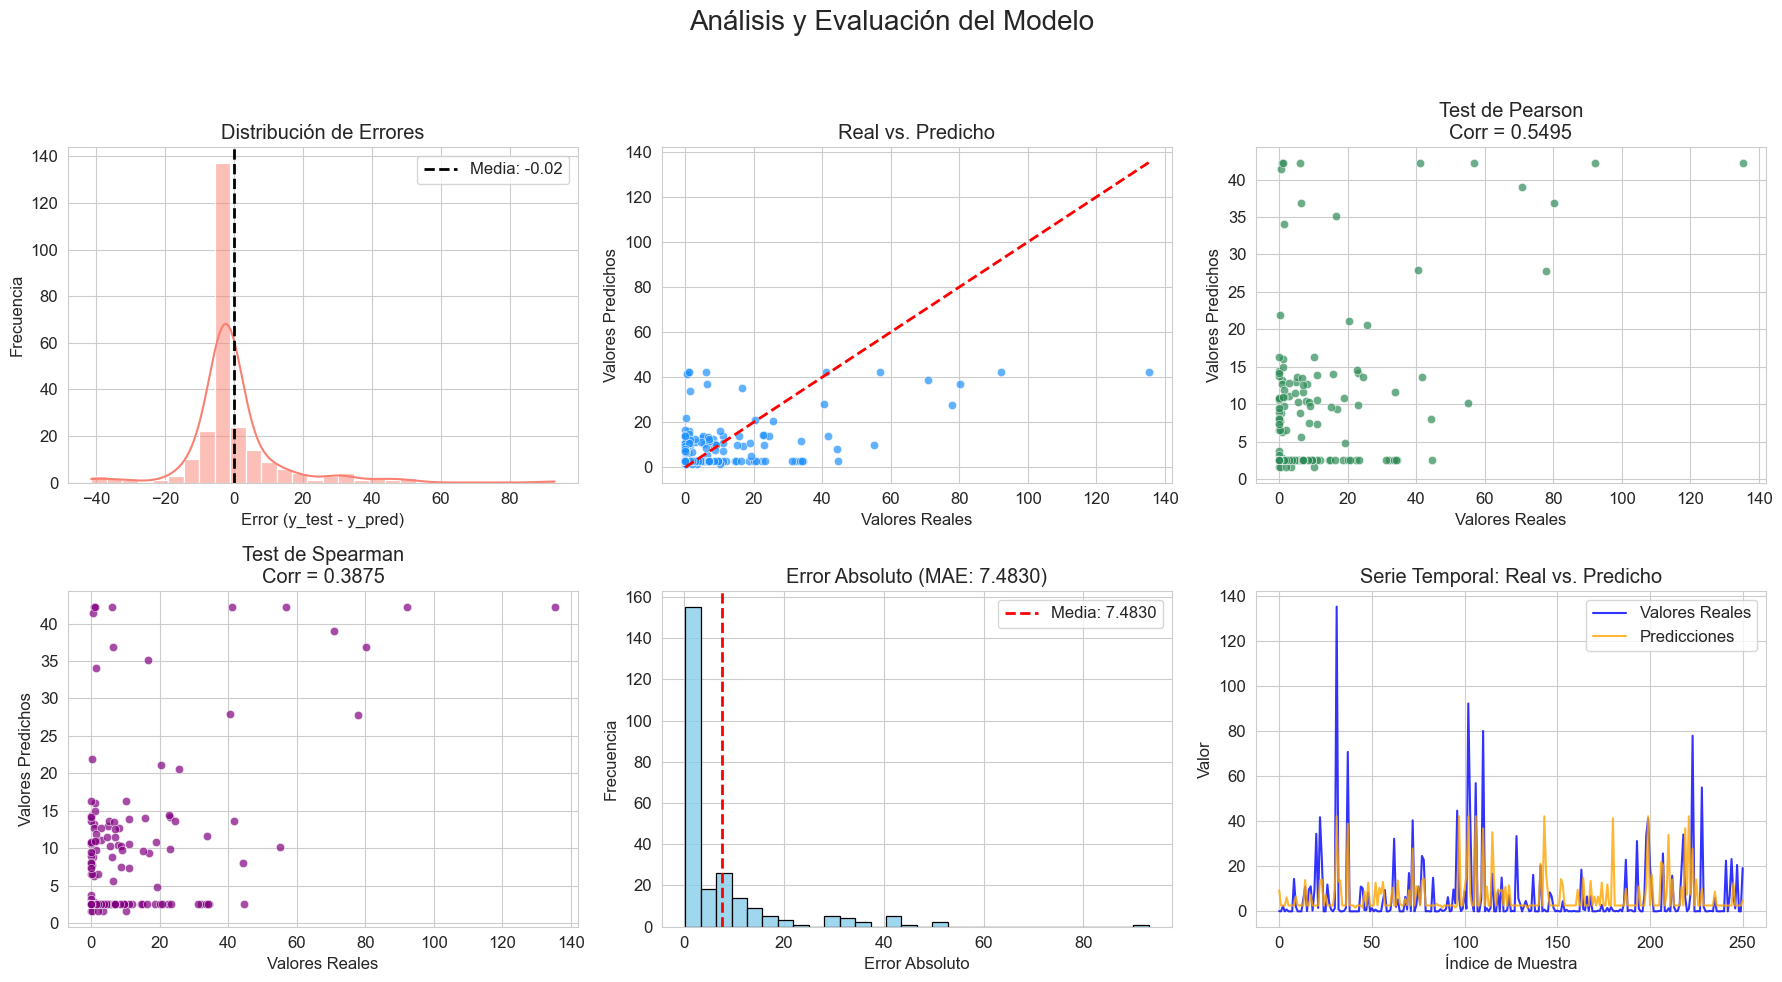

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import shap
import plotly.graph_objects as go
from scipy.stats import pearsonr, spearmanr

# ============================
# CONFIGURACIÓN Y CÁLCULOS INICIALES
# ============================

# (Asegúrate de tener definidas las variables: X_train, X_test, y_test, y_pred y model)

# Calcular errores y métricas de desempeño
errors = y_test - y_pred
abs_error = np.abs(errors)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2') # Validación cruzada para obtener el R² promedio

# Mostrar las métricas calculadas
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"R² de validación cruzada: {cross_val_scores.mean():.4f}")


# Calcular la importancia promedio de cada característica (valor absoluto promedio)
shap_importance = np.abs(shap_values.values).mean(axis=0)
features = X_test.columns

# ============================
# VISUALIZACIÓN CON MATPLOTLIB Y SEABORN
# ============================
# Configurar estilo de Seaborn
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Creamos un dashboard en Matplotlib con 2 filas y 3 columnas
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Análisis y Evaluación del Modelo", fontsize=20, y=0.98)

# --- 1. Distribución de errores (con signo) ---
ax = axs[0, 0]
sns.histplot(errors, bins=30, kde=True, color="salmon", ax=ax)
ax.axvline(errors.mean(), color='black', linestyle='dashed', linewidth=2, label=f"Media: {errors.mean():.2f}")
ax.set_xlabel("Error (y_test - y_pred)")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución de Errores")
ax.legend()

# --- 2. Gráfico de dispersión: Valores Reales vs. Predichos ---
ax = axs[0, 1]
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="dodgerblue", ax=ax)
# Línea de referencia ideal: predicción perfecta
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
ax.set_xlabel("Valores Reales")
ax.set_ylabel("Valores Predichos")
ax.set_title("Real vs. Predicho")

# --- 3. Test de Pearson ---
pearson_corr, _ = pearsonr(y_test, y_pred)
ax = axs[0, 2]
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="seagreen", ax=ax)
ax.set_xlabel("Valores Reales")
ax.set_ylabel("Valores Predichos")
ax.set_title(f"Test de Pearson\nCorr = {pearson_corr:.4f}")

# --- 4. Test de Spearman ---
spearman_corr, _ = spearmanr(y_test, y_pred)
ax = axs[1, 0]
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="purple", ax=ax)
ax.set_xlabel("Valores Reales")
ax.set_ylabel("Valores Predichos")
ax.set_title(f"Test de Spearman\nCorr = {spearman_corr:.4f}")

# --- 5. Distribución del error absoluto ---
ax = axs[1, 1]
sns.histplot(abs_error, bins=30, edgecolor='black', color="skyblue", alpha=0.8, ax=ax)
ax.axvline(abs_error.mean(), color='red', linestyle='dashed', linewidth=2, label=f"Media: {abs_error.mean():.4f}")
ax.set_xlabel("Error Absoluto")
ax.set_ylabel("Frecuencia")
ax.set_title(f"Error Absoluto (MAE: {mae:.4f})")
ax.legend()

# --- 6. Comparación secuencial: Predicción vs. Real a lo largo de las muestras ---
ax = axs[1, 2]
indices = np.arange(len(y_test))
ax.plot(indices, y_test, label='Valores Reales', linestyle='-', color="blue", alpha=0.8)
ax.plot(indices, y_pred, label='Predicciones', linestyle='-', color="orange", alpha=0.8)
ax.set_xlabel("Índice de Muestra")
ax.set_ylabel("Valor")
ax.set_title("Serie Temporal: Real vs. Predicho")
ax.legend()

# Ajuste final de los subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserva espacio para el título principal
plt.show()


# 🔍 Imputación de Valores Faltantes con RandomForest

Este script utiliza un modelo **RandomForest** para predecir valores faltantes en un dataset, escalando previamente las estaciones predictoras (`point_12` y `point_6`).

## ⚙️ **Pasos del Proceso**
1. **Inicialización:** Se crea la columna `value_complet` para almacenar los valores predichos.
2. **Escalado:** Se normalizan `point_12` y `point_6` con `StandardScaler`.
3. **Predicción de Valores Faltantes:**
   - Si `value` está ausente pero hay datos en las estaciones predictoras, se usa el modelo para predecir.
   - Si `value` está presente, se conserva.
   - Si todos los valores están ausentes, se asigna `NaN`.
4. **Comparación:** Se muestran los promedios antes y después de la imputación.



In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Suponiendo que ya tienes el modelo RandomForest 'regr' entrenado y el scaler ajustado

# Crear una nueva columna para los valores predichos
dataset_model["value_complet"] = 0.0  # Crear columna vacía para los valores completados
display(dataset_model)


'''# Ajustar la media
ajuste = dataset_model['value_complet'].mean() - dataset_model['value'].mean()
dataset_model['value_complet'] = dataset_model['value_complet'] - ajuste'''

# Escalar las columnas de las estaciones predictoras
scaler = StandardScaler()
scaler.fit(dataset_model[['point_12', 'point_6']])

# Reemplazar valores faltantes usando el modelo RandomForest
for index, row in dataset_model.iterrows():
    if np.isnan(row["value"]) and ~np.isnan(row["point_12"]) and ~np.isnan(row["point_6"]): 
        # Si el valor está ausente y las estaciones predictoras tienen datos
        row_scaled = scaler.transform(pd.DataFrame([[row["point_12"], row["point_6"]]], columns=["point_12", "point_6"]))
        dataset_model.loc[index, ["value_complet"]] = model.predict(row_scaled)  # Predecir el valor faltante
    elif ~np.isnan(row["value"]):  
        # Si el valor ya está presente, dejarlo intacto
        dataset_model.loc[index, ["value_complet"]] = row["value"]
    else:
        # Si hay datos faltantes en todas las columnas, asignar NaN
        dataset_model.loc[index, ["value_complet"]] = np.nan

# Mostrar los promedios
print(f'Promedio Real: {dataset_model["value"].mean():.2f}')
print(f'Promedio Modelo: {dataset_model["value_complet"].mean():.2f}')

,point_12,point_6,value,value_complet
timestamp,,,,
2009-02-01,0.000000,0.000000,0.0,0.0
2009-02-02,16.109703,0.000000,0.7,0.0
2009-02-03,16.109703,29.260645,23.3,0.0
2009-02-04,0.000000,0.000000,0.0,0.0
2009-02-05,0.000000,0.000000,0.0,0.0
...,...,...,...,...
2012-12-27,0.000000,0.000000,0.0,0.0
2012-12-28,0.000000,0.000000,0.0,0.0
2012-12-29,0.000000,0.000000,0.0,0.0


d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names

d:\master BigData\01

Promedio Real: 6.39
Promedio Modelo: 5.91


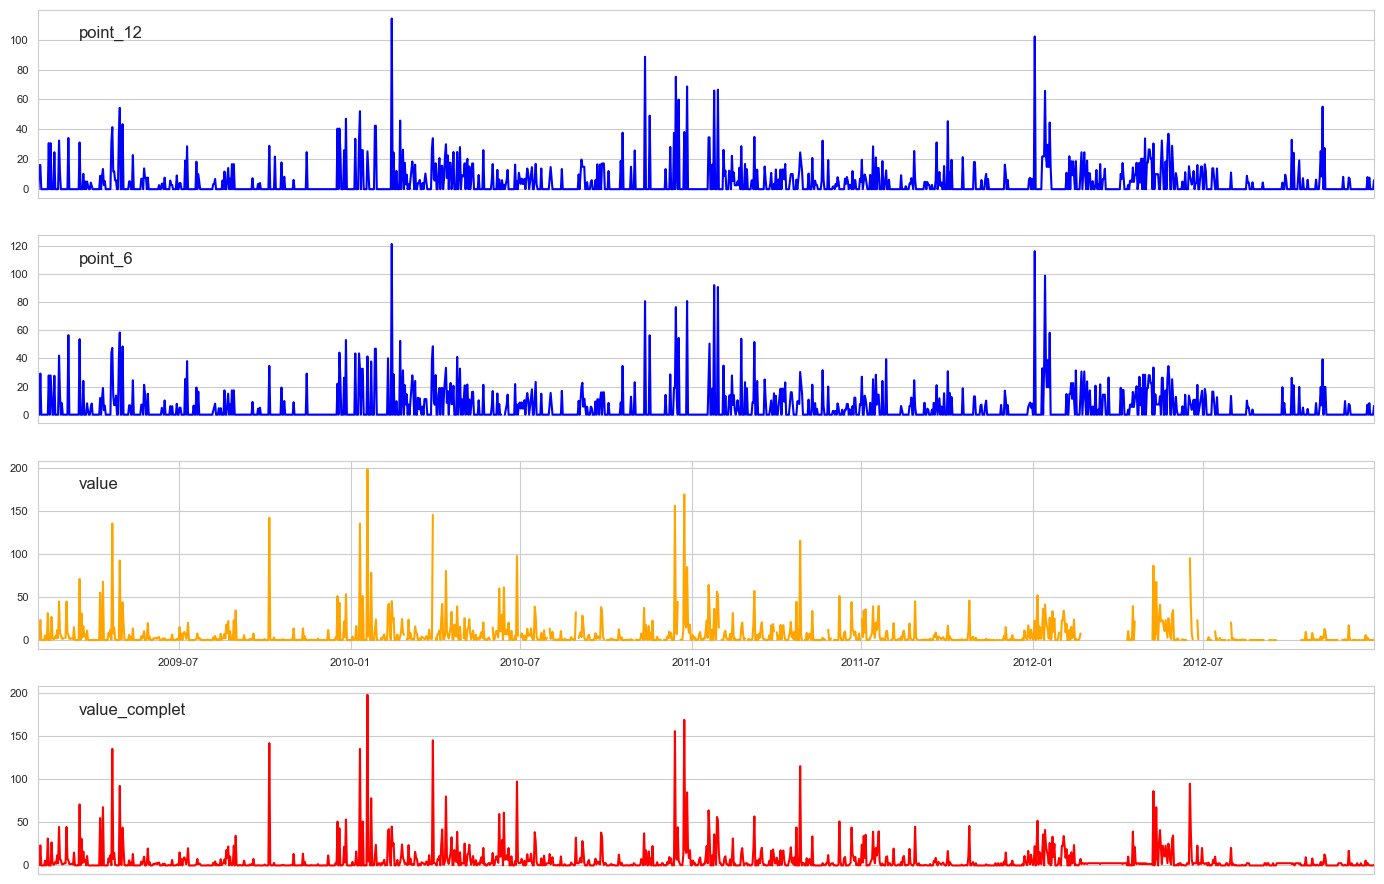

In [26]:
#Gráfica
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 9)) # Ajustar el número de "nrows" por el número de columnas a gráficar
colores = ['blue', 'blue', 'orange', 'red']
for i, col in enumerate(dataset_model.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(dataset_model.index, dataset_model[col], color=colores[i%len(colores)])
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(dataset_model.index.min(), dataset_model.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
    if i != len(dataset_model.columns[1:]) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('', fontsize=6)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [27]:
from graphics_utils.go import multi_line

fig = multi_line(original=dataset_model['value'], Recostruccion = dataset_model['value_complet'])
fig.show()

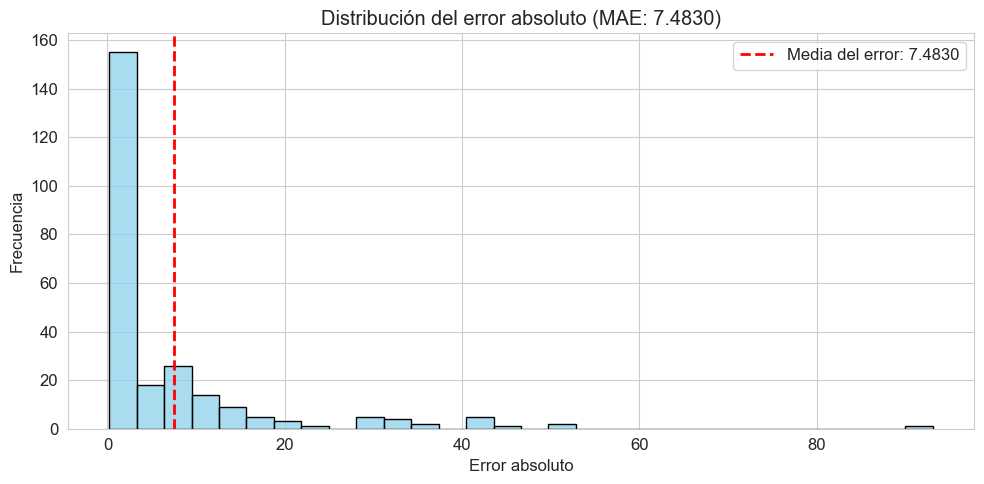

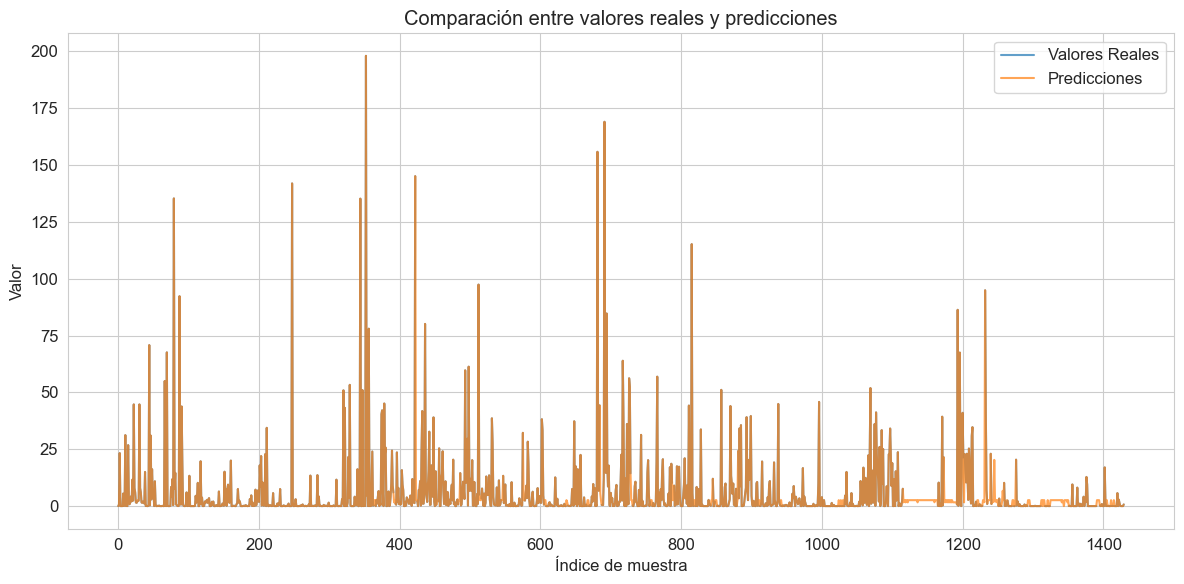

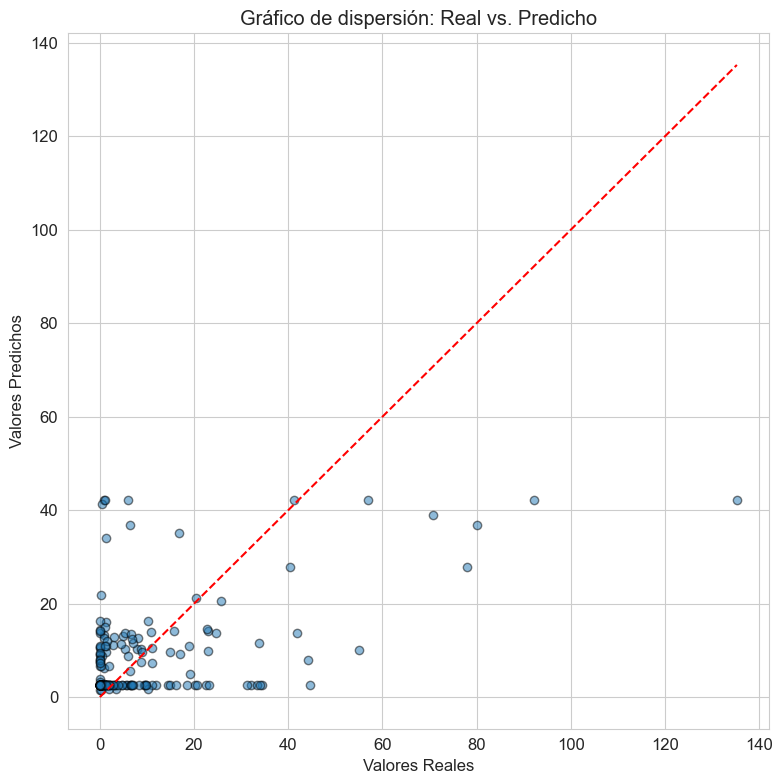

In [28]:
# --- Gráficos de evaluación y análisis ---

# 1. Calcular el error absoluto
error = np.abs(y_test - y_pred)

# Calcular el MAE para los gráficos (ya calculado antes)
# Configurar el estilo de los gráficos
sns.set_style("whitegrid")

# --- 2. Gráfico del error absoluto ---
plt.figure(figsize=(10, 5))
sns.histplot(error, bins=30, edgecolor='black', color="skyblue", alpha=0.7)
plt.axvline(error.mean(), color='red', linestyle='dashed', linewidth=2,
            label=f'Media del error: {error.mean():.4f}')
plt.xlabel("Error absoluto")
plt.ylabel("Frecuencia")
plt.title(f"Distribución del error absoluto (MAE: {mae:.4f})")
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Comparación de predicción vs. real ---
plt.figure(figsize=(12, 6))
# Usamos np.arange para mayor claridad
indices = np.arange(len(dataset_model['value']))
plt.plot(indices, dataset_model['value'], label='Valores Reales', linestyle='-', alpha=0.7)
plt.plot(indices, dataset_model['value_complet'], label='Predicciones', linestyle='-', alpha=0.7)
plt.xlabel("Índice de muestra")
plt.ylabel("Valor")
plt.title("Comparación entre valores reales y predicciones")
plt.legend()
plt.tight_layout()
plt.show()

# --- 4. Gráfico de dispersión: Real vs. Predicho ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='black')
# Línea ideal: donde las predicciones serían perfectas
min_val, max_val = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed')
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predichos")
plt.title("Gráfico de dispersión: Real vs. Predicho")
plt.tight_layout()
plt.show()